In [1]:
# Load the datasets
import pandas as pd

# Load both H1 (Resort Hotel) and H2 (City Hotel)
data_h1 = pd.read_csv('dataset/H1.csv')
data_h1['Hotel'] = 'H1'
data_h2 = pd.read_csv('dataset/H2.csv')
data_h2['Hotel'] = 'H2'

# Concatenate datasets (Resort and City hotel)
data_combined = pd.concat([data_h1, data_h2], ignore_index=True)

# Initial data inspection
data_combined.head()

data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119390 non-null  int64  
 1   LeadTime                     119390 non-null  int64  
 2   ArrivalDateYear              119390 non-null  int64  
 3   ArrivalDateMonth             119390 non-null  object 
 4   ArrivalDateWeekNumber        119390 non-null  int64  
 5   ArrivalDateDayOfMonth        119390 non-null  int64  
 6   StaysInWeekendNights         119390 non-null  int64  
 7   StaysInWeekNights            119390 non-null  int64  
 8   Adults                       119390 non-null  int64  
 9   Children                     119386 non-null  float64
 10  Babies                       119390 non-null  int64  
 11  Meal                         119390 non-null  object 
 12  Country                      118902 non-null  object 
 13 

In [2]:
from datetime import datetime, timedelta

# data_cleaned = data_combined.drop_duplicates()
data_cleaned = data_combined.copy()

# Convert categorical month to numerical 1-12
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']
data_cleaned['ArrivalDateMonth'] = data_cleaned['ArrivalDateMonth'].apply(lambda x: months.index(x) + 1)

# 'Children' missing values can be filled with 0
data_cleaned['Children'] = data_cleaned['Children'].fillna(0)

# Replace SC with Undefined in Meal column
data_cleaned['Meal'] = data_cleaned['Meal'].str.strip()
data_cleaned['Meal'] = data_cleaned['Meal'].replace('SC', 'Undefined')

# deletion on rows that have missing distribution_channel, market_segment feature values.
data_cleaned = data_cleaned.dropna(subset=['DistributionChannel', 'MarketSegment'])
data_cleaned = data_cleaned[data_cleaned['DistributionChannel'] != 'Undefined']

# Clean data to remove any leading/trailing spaces
data_cleaned['ReservedRoomType'] = data_cleaned['ReservedRoomType'].str.strip()
data_cleaned['DistributionChannel'] = data_cleaned['DistributionChannel'].str.strip()

data_cleaned = data_cleaned.drop(columns=['Country'])

# Some rows contain entries with 0 adults, 0 children and 0 babies. 
zero_guests = list(data_cleaned.loc[data_cleaned["Adults"]
                   + data_cleaned["Children"]
                   + data_cleaned["Babies"]==0].index)
data_cleaned = data_cleaned.drop(data_cleaned.index[zero_guests])

# Inspect the cleaned data
data_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 119205 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119205 non-null  int64  
 1   LeadTime                     119205 non-null  int64  
 2   ArrivalDateYear              119205 non-null  int64  
 3   ArrivalDateMonth             119205 non-null  int64  
 4   ArrivalDateWeekNumber        119205 non-null  int64  
 5   ArrivalDateDayOfMonth        119205 non-null  int64  
 6   StaysInWeekendNights         119205 non-null  int64  
 7   StaysInWeekNights            119205 non-null  int64  
 8   Adults                       119205 non-null  int64  
 9   Children                     119205 non-null  float64
 10  Babies                       119205 non-null  int64  
 11  Meal                         119205 non-null  object 
 12  MarketSegment                119205 non-null  object 
 13  Dist

In [3]:
# data_cleaned.sort_values(by=['ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth'], inplace=True)
# X = data_cleaned.drop(columns='IsCanceled')
# y = data_cleaned['IsCanceled']

In [4]:
from sklearn.model_selection import train_test_split

def convenient_split_data(data):
    """
    Perform stratified split on the data

    Parameters
    ----------
    data : pd.DataFrame
        The data to split

    Returns
    -------
    X_train : pd.DataFrame
        The training data
    X_test : pd.DataFrame   
        The testing data
    y_train : pd.Series
        The training target
    y_test : pd.Series
        The testing target
    """
    
    data = data.sort_values(by=['ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth'])
    
    X = data.drop(columns=['IsCanceled'])
    y = data['IsCanceled']
    
    X['YearMonth'] = X['ArrivalDateYear'].astype(str) + '-' + X['ArrivalDateMonth'].astype(str)
    
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
    
    # Loop over each block and perform stratified split
    for block in X['YearMonth'].unique():
        X_block = X[X['YearMonth'] == block].drop(columns=['YearMonth'])
        y_block = y[X['YearMonth'] == block]
        
        X_train_block, X_test_block, y_train_block, y_test_block = train_test_split(
            X_block, y_block, test_size=0.25, stratify=y_block, random_state=42)
        
        X_train_list.append(X_train_block)
        X_test_list.append(X_test_block)
        y_train_list.append(y_train_block)
        y_test_list.append(y_test_block)
    
    X_train = pd.concat(X_train_list)
    X_test = pd.concat(X_test_list)
    y_train = pd.concat(y_train_list)
    y_test = pd.concat(y_test_list)

    return X_train, X_test, y_train, y_test

X_convenient_train, X_convenient_test, y_convenient_train, y_convenient_test = convenient_split_data(data_cleaned)

<hr>

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class Wrapper(BaseEstimator, TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        self.transformer.is_test = False
        return self.transformer.fit(X, y)
    
    def transform(self, X):
        self.transformer.is_test = True 
        return self.transformer.transform(X)
    
    def fit_transform(self, X, y=None):
        self.transformer.is_test = False  
        return self.transformer.fit_transform(X, y)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime, timedelta

class BookingFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, is_test=False):
        self.is_test = is_test
        pass
    
    def fit(self, X, y=None):        
        return self
    
    def transform(self, X):        
        # Create 'LiveTime' feature
        X['LiveTime'] = X.apply(lambda row: self.calculate_livetime(X, row), axis=1)

         # Calculate the 75th percentile of ADR for each group
        X['ThirdQuartileADR'] = X.groupby(['DistributionChannel', 'ReservedRoomType', 'ArrivalDateYear'])['ADR'].transform(lambda x: x.quantile(0.75))

        # Calculate ADRThirdQuartileDeviation
        X['ADRThirdQuartileDeviation'] = X.apply(
            lambda row: row['ADR'] / row['ThirdQuartileADR'] if row['ThirdQuartileADR'] > 0 else 0,
            axis=1
        )

        X = X.drop(columns=['LeadTime',
                            'ADR', 
                            'ThirdQuartileADR',
                            'ArrivalDateYear',
                            'ArrivalDateMonth', 
                            'ArrivalDateWeekNumber',
                            'ArrivalDateDayOfMonth', 
                            'ReservationStatus', 
                            'ReservationStatusDate',
                            'ReservedRoomType', 
                            'AssignedRoomType',
                            'RequiredCarParkingSpaces'])
        
        return X

    def calculate_livetime(self, X, row):
        arrival_date = datetime(row['ArrivalDateYear'], row['ArrivalDateMonth'], row['ArrivalDateDayOfMonth'])
        booking_date = arrival_date - timedelta(days=row['LeadTime'])

        if self.is_test:
            # 'C' booking type (current bookings)
            processing_date = arrival_date - timedelta(weeks=2)
            if (processing_date - booking_date).days < 0:
                return 0
            return (processing_date - booking_date).days
        else:
            if row['ReservationStatus'] == 'Check-Out':  # "A" type (effective bookings)
                return row['LeadTime']
            else:  # "B" type (canceled bookings or no show)
                reservation_status_date = datetime.strptime(row['ReservationStatusDate'], "%Y-%m-%d")
                # print('Canceled booking:', (reservation_status_date-booking_date).days)
                return (reservation_status_date - booking_date).days


In [7]:
import numpy as np

class LogitOddsEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, target_col='IsCanceled', min_frequency=0.02, smoothing=1e-6):
        self.target_col = target_col
        self.min_frequency = min_frequency
        self.smoothing = smoothing
        self.logit_odds_map = {}
        self.global_mean_logit_odds = None
    
    def fit(self, X, y=None):
        # Store global logit odds as a fallback for unseen categories
        global_mean = y.mean()
        self.global_mean_logit_odds = np.log(global_mean / (1 - global_mean))

        for col in X.columns:
            counts = X[col].value_counts(normalize=True)
            common_levels = counts[counts >= self.min_frequency].index
            group_data = X[[col]].copy()
            group_data[self.target_col] = y
            
            # Calculate logit odds with proper handling of 0 and 1 values
            logit_odds = group_data.groupby(col)[self.target_col].mean().apply(
                lambda x: np.log(np.clip(x, self.smoothing, 1 - self.smoothing) / 
                                 (1 - np.clip(x, self.smoothing, 1 - self.smoothing)))
            )
            self.logit_odds_map[col] = logit_odds.reindex(common_levels).fillna(self.global_mean_logit_odds)
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        for col in X.columns:
            # Map the logit odds to the column, filling with the global mean logit odds if not found
            X_encoded[col] = X[col].map(self.logit_odds_map[col]).fillna(self.global_mean_logit_odds)
        return X_encoded

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Define preprocessing for numerical and categorical columns
numerical_features = ['LiveTime', 
                      'StaysInWeekendNights', 
                      'StaysInWeekNights', 
                      'Adults', 
                      'Children', 
                      'Babies', 
                      'ADRThirdQuartileDeviation', 
                      'IsRepeatedGuest', 
                      'PreviousCancellations', 
                      'PreviousBookingsNotCanceled', 
                      'BookingChanges', 
                      'DaysInWaitingList', 
                      'TotalOfSpecialRequests']
categorical_features = ['DepositType', 
                        'DistributionChannel', 
                        'CustomerType', 
                        'Meal', 
                        'MarketSegment', 
                        'Hotel',
                        'Agent', 
                        'Company']

# Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features[:-2]),  # Apply OHE to other categorical features
        ('logit_odds', LogitOddsEncoder(), ['Agent', 'Company']) 
    ])


In [9]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Bagging': BaggingClassifier(random_state=42),
    'Bayesian': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42)
}

# Define scoring metrics for cross_validate
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc' ]

# Perform cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lista per salvare i risultati
all_results = []

# Esegui TimeSeriesSplit per ognuno dei modelli
for model_name, model in models.items():

    # Create a pipeline with SMOTE and the model
    pipeline = Pipeline(steps=[
        ('feature_transformer', Wrapper(BookingFeaturesTransformer())),  # Feature engineering
        ('preprocessing', preprocessor),                        # Preprocessing (StandardScaler, OneHotEncoder, Logit-Odds)
        ('smote', SMOTE(random_state=42)),                      # Apply SMOTE to balance the classes
        ('model', model)                                        # The current model
    ])

    y_true = []
    y_pred = []

    # Perform cross-validation
    for train_index, test_index in skf.split(X_convenient_train, y_convenient_train):
        X_train, X_test = X_convenient_train.iloc[train_index], X_convenient_train.iloc[test_index]
        y_train, y_test = y_convenient_train.iloc[train_index], y_convenient_train.iloc[test_index]
        
        # Fit the pipeline on training data
        pipeline.fit(X_train, y_train)

        # Predict on test data
        y_pred_fold = pipeline.predict(X_test)

        # Collect true and predicted values
        y_true.extend(y_test)
        y_pred.extend(y_pred_fold)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    # Store results
    all_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
    })

    # TODO: wilcoxon or t-test to compare models

results_df = pd.DataFrame(all_results)
results_df

/var/folders/cr/n708zkvn3yl95rky5npx_kzw0000gn/T/ipykernel_39874/2322808232.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['LiveTime'] = X.apply(lambda row: self.calculate_livetime(X, row), axis=1)
/var/folders/cr/n708zkvn3yl95rky5npx_kzw0000gn/T/ipykernel_39874/2322808232.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ThirdQuartileADR'] = X.groupby(['DistributionChannel', 'ReservedRoomType', 'ArrivalDateYear'])['ADR'].transform(lambda x: x.quantile(0.75))
/var/folders/cr/n708zkvn3yl95rky5n

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest,0.768860,0.711062,0.634230,0.670452,0.741201
1,Logistic Regression,0.740302,0.654687,0.633747,0.644046,0.718411
2,AdaBoost,0.738366,0.649828,0.638122,0.643922,0.717772
3,Decision Tree,0.717135,0.610309,0.655593,0.632141,0.704492
4,K-Nearest Neighbors,0.748523,0.657459,0.671525,0.664418,0.732705
5,Bagging,0.753870,0.689602,0.611176,0.648025,0.724555
6,Bayesian,0.665992,0.536126,0.734830,0.619945,0.680134
7,XGBoost,0.759754,0.695573,0.625871,0.658884,0.732249


Accuracy: 0.7578248180079842
Precision: 0.69313824419778
Recall: 0.6217977731510818
F1 Score: 0.6555327575511762
ROC AUC: 0.7298574197809561


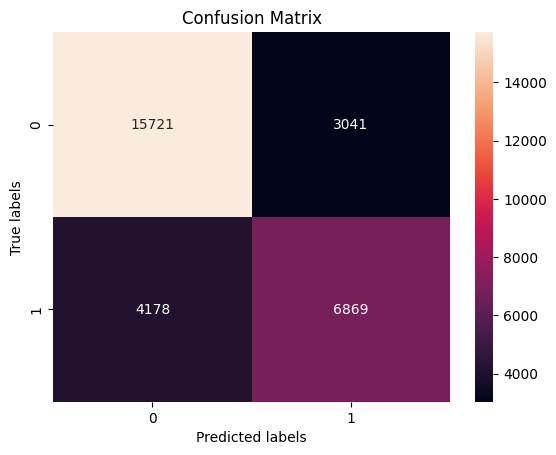

In [10]:
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

pipeline = Pipeline(steps=[
    ('feature_transformer', Wrapper(BookingFeaturesTransformer())),  # Feature engineering
    ('preprocessing', preprocessor),                                 # Preprocessing (StandardScaler, OneHotEncoder, Logit-Odds)
    ('smote', SMOTE(random_state=42)),                              # Apply SMOTE to balance the classes
    ('model', XGBClassifier(random_state=42))                       # The current model
])

pipeline.fit(X_convenient_train, y_convenient_train)

y_pred = pipeline.predict(X_convenient_test)

accuracy = accuracy_score(y_convenient_test, y_pred)
precision = precision_score(y_convenient_test, y_pred)
recall = recall_score(y_convenient_test, y_pred)
f1 = f1_score(y_convenient_test, y_pred)
roc_auc = roc_auc_score(y_convenient_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('ROC AUC:', roc_auc)

cm = confusion_matrix(y_convenient_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [11]:
from sklearn.model_selection import GridSearchCV

# Define the parameters to tune
param_grid = {
    'model__n_estimators': [100, 200], 
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.1, 0.01]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=skf, n_jobs=-1)
grid_search.fit(X_convenient_train, y_convenient_train)

# View best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC: ", grid_search.best_score_)


Best parameters found:  {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Best ROC AUC:  0.8233801814395116


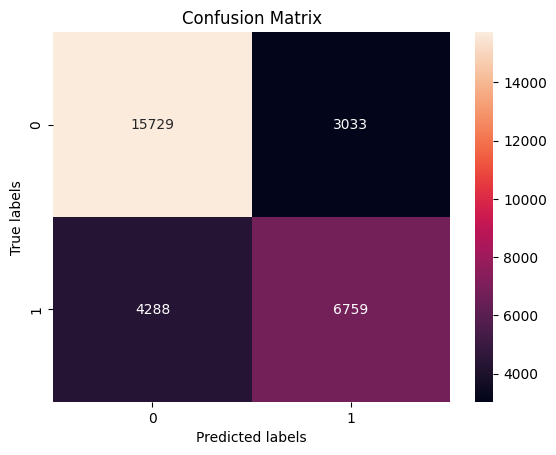

{'Accuracy': 0.7544030326411486,
 'Precision': np.float64(0.6902573529411765),
 'Recall': np.float64(0.6118403186385444),
 'F1 Score': np.float64(0.6486875569845002),
 'ROC AUC': np.float64(0.7250918894120129)}

In [13]:
# Let's define the model with the best parameters and rerun it
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Best parameters from grid search
best_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 200
}

# Define the pipeline with the best model parameters
best_pipeline = Pipeline(steps=[
    ('feature_transformer', Wrapper(BookingFeaturesTransformer())),  # Feature engineering
    ('preprocessing', preprocessor),                                 # Preprocessing (StandardScaler, OneHotEncoder, etc.)
    ('smote', SMOTE(random_state=42)),                               # Balancing classes using SMOTE
    ('model', XGBClassifier(random_state=42, **best_params))         # Best model with tuned hyperparameters
])

# Fit the model on the training data
best_pipeline.fit(X_convenient_train, y_convenient_train)

# Predictions
y_pred = best_pipeline.predict(X_convenient_test)

# Calculate metrics
accuracy = accuracy_score(y_convenient_test, y_pred)
precision = precision_score(y_convenient_test, y_pred)
recall = recall_score(y_convenient_test, y_pred)
f1 = f1_score(y_convenient_test, y_pred)
roc_auc = roc_auc_score(y_convenient_test, y_pred)

# Output the metrics
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
}

# Display confusion matrix
cm = confusion_matrix(y_convenient_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

metrics


[0.01169793 0.01056396 0.0198512  0.00587544 0.00384011 0.0017446
 0.0048736  0.00507754 0.04514234 0.01586857 0.01475244 0.00571746
 0.03890724 0.01237155 0.6144431  0.         0.00281199 0.00377732
 0.00070641 0.0044749  0.00906811 0.00285644 0.02706938 0.02028321
 0.00439835 0.00438528 0.00900587 0.00459944 0.00179384 0.00340905
 0.00243425 0.00560599 0.005666   0.00962098 0.00716084 0.00685018
 0.         0.04088539 0.01240964]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (39,) and arg 3 with shape (33,).

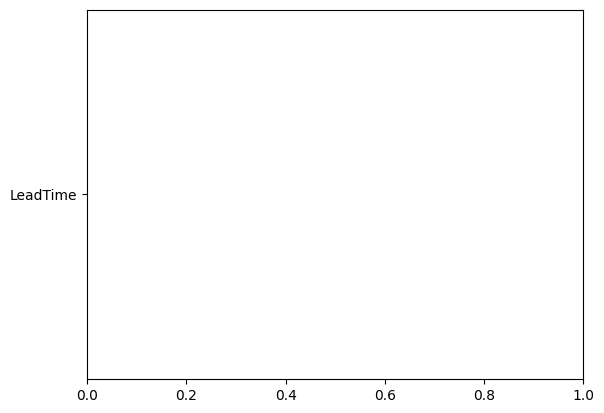

In [14]:
model = best_pipeline.named_steps['model']  # Access XGBoost from the pipeline
importance = model.feature_importances_
print(importance)
plt.barh(X_convenient_train.columns, importance)
plt.show()